## Model Interpretation for Trained VGG-16 Model

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
#from GPUtil import showUtilization as gpu_usage

import torchvision
from torchvision import models
from torchvision import transforms
from torchvision.models import resnet50

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

### Get Hardware Device

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(device))

NVIDIA GeForce RTX 3080


In [3]:
file_path='../model_dev/vgg16_ft.pth'

In [4]:
def load_vgg_model(path):
    
    model = models.vgg16(weights=None)
    num_features = model.classifier[6].in_features
    features = list(model.classifier.children())[:-1]
    features.extend([nn.Linear(num_features, 2)])
    model.classifier = nn.Sequential(*features)

    model.load_state_dict(torch.load(path))
    model.eval()
    model = model.to(device)
    
    return model

In [5]:
model = load_vgg_model(file_path)

In [6]:
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

img = Image.open('../model_dev/Data_CMC_COADEL_224_1/val/Mitosis/10003.jpg')
#img = Image.open('/content/27900.jpg')
transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

In [7]:
input = input.to(device)

with torch.no_grad():
    output = model(input) #.to(device)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)

    pred_label_idx.squeeze_()
    predicted_label = str(pred_label_idx.item())
    print(output)
    print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

tensor([[9.9924e-01, 7.6119e-04]], device='cuda:0')
Predicted: 0 ( 0.9992388486862183 )


In [12]:
#print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')
with torch.no_grad():
    integrated_gradients = IntegratedGradients(model)
    attributions_ig = integrated_gradients.attribute(input, target=1)#, n_steps=200)

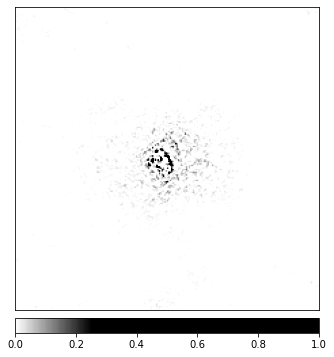

In [9]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

In [ ]:
gpu_usage()

| ID | GPU | MEM |
------------------
|  0 |  3% |  6% |
|  1 |  0% | 70% |


In [ ]:
from numba import cuda
torch.cuda.empty_cache()

cuda.select_device(1)
cuda.close()
cuda.select_device(1)

<weakproxy at 0x7fee065c31a0 to Device at 0x7fee065cce20>

In [ ]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', target=1)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

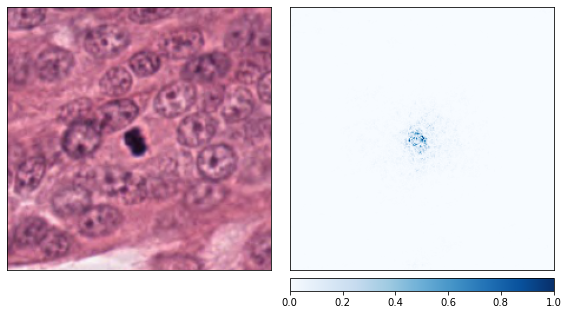

In [9]:
torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([input * 0, input * 1])

attributions_gs = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      #cmap=default_cmap,
                                      show_colorbar=True)

In [8]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)

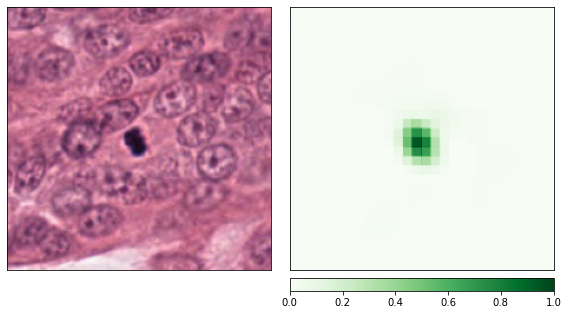

In [9]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

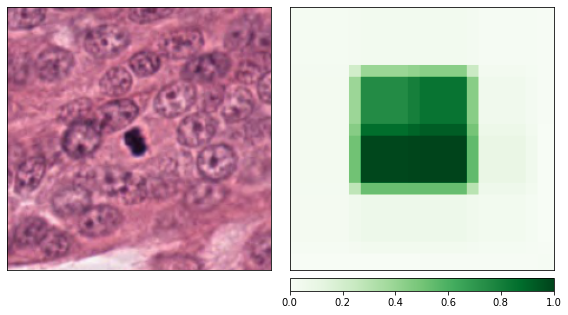

In [10]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 50, 50),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,60, 60),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )